# Using AMASS for training DNNs for Human Body and Motion
AMASS is a large database of human bodies, ready to enable proper deep learning on human body. Instead of images, as in [ImageNet](http://www.image-net.org/),
 AMASS consists of human body parameters, controlling the surface mesh of the [SMPL](http://smpl.is.tue.mpg.de/) body model family.

Here we provide basic tools to turn AMASS bodies into suitable formats for deep learning frameworks.
We produce PyTorch readable *.pt*, as well as *.h5* files.

The provided data preparation code has three stages that could be flexibly customized to your own specific needs.

**Stage I** goes over the previously downloaded numpy npz files, sub-samples the time-length and dumps the result into one place as PyTorch pt files.

**Stage II** uses PyTorch to apply all sorts of data augmentations in parallel on the original data and produces HDF5 files.
HDF5 makes it possible to write files in chunks to avoid memory shortage,
while PyTorch speeds up data augmentation though batch processing .

**Stage III** simply turns the h5 files into pt files again to be readily usable by PyTorch.
One can replace this stage's output to any other suitable kind.

The progress at all stages is logged and could be inspected at any time during the process or later.
We suggest using an experiment ID that would help in referring to a specific, traceable, data preparation run.

Dependencies to run this notebook:
- [Human Body Prior](https://github.com/nghorbani/human_body_prior)
- [PyTorch>=1.7.0](https://pytorch.org/)
- [PyTables](https://www.pytables.org/usersguide/installation.html)
- [tqdm](https://pypi.org/project/tqdm/2.2.3/)

Before you continue with this tutorial, it is recommended to first take a look at the [**AMASS Visualization**](01-AMASS_Visualization.ipynb) notebook.

In [1]:
# Preparing the environment
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

import os
from os import path as osp
os.environ['PYOPENGL_PLATFORM'] = 'egl'
import numpy as np
import torch

support_dir = '../support_data/'

# Choose the device to run the body model on.
comp_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from human_body_prior.tools.omni_tools import log2file, makepath
from human_body_prior.tools.omni_tools import copy2cpu as c2c



from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import glob 

class MocapDataSet(Dataset):
    def __init__(self,data_dir):
        self.data_dir=data_dir
        self.xy = torch.load(self.data_dir)
    
    def __len__(self):
        return len(self.xy)
    
    def __getitem__(self,i):
        return self.xy[i]
    

In [2]:
def iterate_data(data_dir):
    xy_pairs = torch.empty(size=(0,2,10,156))
    for data_fname in glob.glob(os.path.join(data_dir, '*/*.npz'),recursive=True):
        data = np.load(data_fname)
        xy_pairs = torch.cat((xy_pairs,(make_xy_pairs(data))))
        print(xy_pairs.shape)
    return xy_pairs
# xy_pairs = iterate_data(data_dir="../../amass_data/SFU")

In [3]:
        

def make_xy_pairs(data):
    num_frames = int(data['mocap_framerate']/12)
    xy = [data['poses'][i*num_frames:(i+1)*num_frames] for i in range(len(data['poses'])//num_frames)]
    xy =[[xy[i],xy[i+1]] for i in range(len(xy)-1)]
    return torch.as_tensor(xy).float()
    

In [4]:
dataset = MocapDataSet(data_dir="amass.pt")

In [ ]:
dataset.xy.reshape(*6,2,10,172).shape

In [2]:
xy_pairs

NameError: name 'xy_pairs' is not defined

In [ ]:
dataloader = DataLoader(dataset,batch_size=5,shuffle=True)

In [3]:
import torch.nn as nn
from tqdm import tqdm 

class BaseModel(nn.Module):
    def __init__(self,dim :int):
        super().__init__()
        self.l1 = nn.LSTM(dim,dim,num_layers=5)
#         self.default_hidden = (torch.randn(1,1,169),torch.randn(1,1,169))
    
    def forward(self,x,hidden):
        lstm_out, _ = self.l1(x)
        return lstm_out

dim = 172

model = BaseModel(dim=dim)
model = model.float()
hidden = (torch.randn(1,1,dim).float(),
         torch.randn(1,1,dim).float())

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.1)



for epoch in range(10):
    epoch_loss = 0
    for i, data in enumerate(tqdm(dataloader)):
        
        model.zero_grad()
        x = data[0][0]
        y = data[0][1]
        out= model(torch.unsqueeze(x,1),hidden)
#         print(out.shape,y.shape)
        loss = criterion(out[:,0,:],y)
        
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
    print(epoch_loss/len(dataloader))

NameError: name 'dataloader' is not defined

In [39]:
with torch.no_grad():
    pred = model(torch.unsqueeze(data[0][0],1),hidden)
    
    
    frames = {"pose_body":pred[:,0,3:66],"pose_hands":pred[:,0,66:156],"betas":pred[:,0,156:]}
    frames_gt = {"pose_body":data[0][1][:,3:66],"pose_hands":data[0][1][:,66:156],"betas":data[0][1][:,156:]}

print('Body parameter vector shapes: \n{}'.format(' \n'.join(['{}: {}'.format(k,v.shape) for k,v in frames_gt.items()])))

from human_body_prior.body_model.body_model import BodyModel

bm_fname = osp.join(support_dir, 'body_models/smplh/male/model.npz')

num_betas = 16 # number of body parameters
num_dmpls = 8 # number of DMPL parameters

bm = BodyModel(bm_fname=bm_fname, num_betas=num_betas)
faces = c2c(bm.f)

body_pose_hand_gt = bm(**{k:v for k,v in frames_gt.items() if k in ['pose_body', 'betas', 'pose_hand']})
body_pose_hand = bm(**{k:v for k,v in frames.items() if k in ['pose_body', 'betas', 'pose_hand']})

Body parameter vector shapes: 
pose_body: torch.Size([60, 63]) 
pose_hands: torch.Size([60, 90]) 
betas: torch.Size([60, 16])


In [40]:
import trimesh
from body_visualizer.tools.vis_tools import colors
from body_visualizer.mesh.mesh_viewer import MeshViewer
from body_visualizer.mesh.sphere import points_to_spheres
from body_visualizer.tools.vis_tools import show_image

imw, imh=1600, 1600
mv = MeshViewer(width=imw, height=imh, use_offscreen=True)


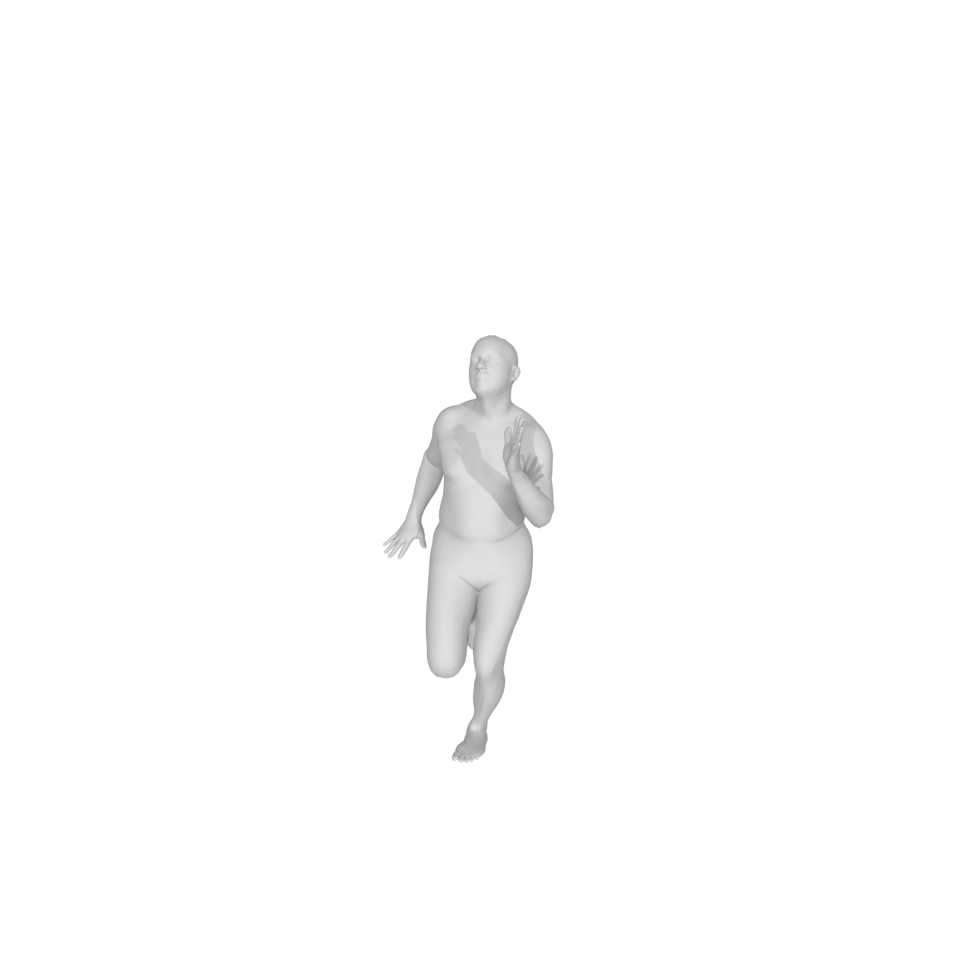

In [41]:

fId=15

def vis_body_pose_hand(fId = 0):
    body_mesh = trimesh.Trimesh(vertices=c2c(body_pose_hand_gt.v[fId]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
    mv.set_static_meshes([body_mesh])
    body_image = mv.render(render_wireframe=False)
    show_image(body_image)

vis_body_pose_hand(fId=fId)

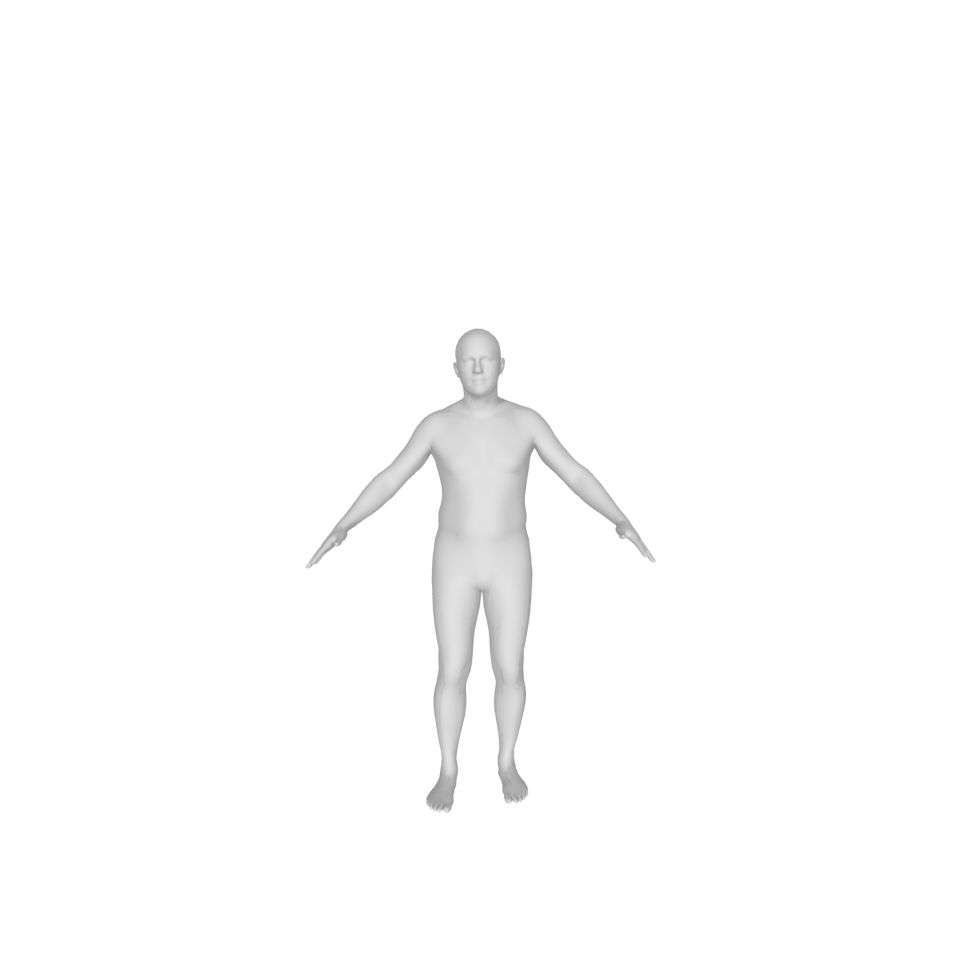

In [56]:
def vis_body_pose_hand(fId = 0):
    body_mesh = trimesh.Trimesh(vertices=c2c(body_pose_hand.v[fId]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
    mv.set_static_meshes([body_mesh])
    body_image = mv.render(render_wireframe=False)
    show_image(body_image)
fId=2
vis_body_pose_hand(fId=fId)

In [20]:
sample = np.load("../../amass_data/ACCAD/Female1Gestures_c3d/D3 - Conversation Gestures_poses.npz")

for k in sample.keys():
    print(k)

trans
gender
mocap_framerate
betas
dmpls
poses


In [35]:
data = make_xy_pairs(sample)

In [33]:
data.shape

torch.Size([607, 2, 10, 156])

In [75]:
xy = [[np.concatenate((data['poses'][i:(i+1)*num_frames],data['betas'].repeat(num_frames,0)),0) for i in range(int(data['mocap_framerate']/12))] for i in range(0,len(data['poses']),int(data['mocap_framerate']/12))]

torch.Size([608, 2, 10, 172])

In [ ]:
sample['poses'].shape

In [8]:
data=sample

In [10]:
num_frames = int(data['mocap_framerate']/12)


In [16]:
d = [data['poses'][i*num_frames:(i+1)*num_frames] for i in range(len(data['poses'])//num_frames)]

In [17]:
d[3].shape

(10, 156)

In [94]:
data['betas'].repeat(num_frames,0).shape

(160,)

In [86]:
beta_filler.shape

(60860, 156)